**Code taken and adapted from Erica's GECM_COMP notebook:**
- Calculate WER per row for pairs
- Check which sentences were grammatically acceptable before / after GEC
- Calculate difference in grammatical score

**New code (JGC):**
- Look at individual sentences

In [34]:
# drive access
from google.colab import drive
drive.mount('/content/drive')

# standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# for evaluation metrics
!pip install jiwer -q
!pip install bert_score -q
!pip install evaluate -q
from evaluate import load
from jiwer import wer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install evaluate -q
from evaluate import load

# Mini example to see what's going on with WER

In [3]:
#with wer.compute
wer = load("wer")

reference = ["hello world", "i like monthy python"]
hypothesis = ["hello duck", "i like python"]

#with jiwer
#error = wer(reference, hypothesis)
error_compute = wer.compute(predictions=hypothesis, references=reference)

error_compute

0.3333333333333333

In [4]:
from jiwer import wer

reference = ["hello world", "i like monthy python"]
hypothesis = ["hello duck", "i like python"]

error = wer(reference, hypothesis)
error

0.3333333333333333

In [5]:
from jiwer import wer

reference1 = "hello world"
hypothesis1 = "hello duck"

reference2 = "i like monthy python"
hypothesis2 = "i like python"

wer1 = wer(reference1, hypothesis1)
wer2 = wer(reference2, hypothesis2)

mean_wer = (wer1+wer2)/2
mean_wer

0.375

# Import results from GEC models

|Model|Grammatical threshold|Improvement threshold|
|-----|---------------------|---------------------|
SIMPLE| 0.5 |0.25|
||0.75|0.25|
||0.90|0.1|
FINETUNED| 0.5 |0.25|
||0.75|0.25|
||0.90|0.1|
PHONETIC| 0.5 |0.25|
||0.75|0.25|
||0.90|0.1|

In [36]:
# list of output datasets and it's characteristics
csv_list = [("0.SimpleGEC/0e_simple_gec_09_01_data.csv", "SimpleGEC", 0.9, 0.1),
          ("0.SimpleGEC/0d_simple_gec_075_025_data.csv", "SimpleGEC", 0.75, 0.25),
          ("0.SimpleGEC/0b_simple_gec_05_025_data.csv", "SimpleGEC", 0.5, 0.25),
          ("1.FineTuneGEC/0e_finetune_gec_09_01_data.csv", "FineTunedGEC", 0.9, 0.1),
          ("1.FineTuneGEC/0d_finetune_gec_075_025_10_data.csv", "FineTunedGEC", 0.75, 0.25),
          ("1.FineTuneGEC/0b_FineTuneGEC_reduced_train_05_025.csv", "FineTunedGEC", 0.5, 0.25),
          ("3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv", "PhoneticGEC", 0.9, 0.1),
          ("3.PhoneticGEC/0d_phoneticv2_gec_075_025_20_data.csv", "PhoneticGEC", 0.75, 0.25),
          ("3.PhoneticGEC/0b_phonetic_gec_05_25_20_data.csv", "PhoneticGEC", 0.5, 0.25),
          ("4.RawGEC/0a.RawGEC_reduced_____010_20.csv", "RawGEC", "", 0.10),
          ("4.RawGEC/0b.RawGEC_reduced_____015_20.csv", "RawGEC", "", 0.15),
          ("4.RawGEC/0c.RawGEC_reduced_____025_20.csv", "RawGEC", "", 0.25)
          ]


column_names = data = ['csvfile', 'modelname', 'thres1', 'thres2', 'filename', 'actor',
                       'gender', 'emotion', 'auto_transcription', 'cleaned_auto_transcription',
                       'cleaned_label', 'GEC_transcription', 'base_score', 'GEC_score']

df = pd.DataFrame(columns=column_names)

for csvfile, modelname, thres1, thres2 in csv_list:
  print(csvfile, modelname, thres1, thres2 )
  aux_df = pd.read_csv('/content/drive/MyDrive/266/Data/GEC_Data/' + csvfile)
  aux_df.insert(0, "thres2", thres2)
  aux_df.insert(0, "thres1", thres1)
  aux_df.insert(0, "modelname", modelname)
  aux_df.insert(0, "csvfile", csvfile)

  aux_df = aux_df.rename(columns={'simpleGEC_score': 'GEC_score'})
  aux_df = aux_df.rename(columns={'GEC_score_dis0': 'GEC_score'})

  aux_df = aux_df.rename(columns={'simpleGEC_transcription': 'GEC_transcription'})
  aux_df = aux_df.rename(columns={'GEC_transcription_dis0': 'GEC_transcription'})

  merge_df = aux_df[column_names]

  df = pd.concat([df, merge_df], ignore_index=True)

print(f"concat df #rows: {len(df)}")

0.SimpleGEC/0e_simple_gec_09_01_data.csv SimpleGEC 0.9 0.1
0.SimpleGEC/0d_simple_gec_075_025_data.csv SimpleGEC 0.75 0.25
0.SimpleGEC/0b_simple_gec_05_025_data.csv SimpleGEC 0.5 0.25
1.FineTuneGEC/0e_finetune_gec_09_01_data.csv FineTunedGEC 0.9 0.1
1.FineTuneGEC/0d_finetune_gec_075_025_10_data.csv FineTunedGEC 0.75 0.25
1.FineTuneGEC/0b_FineTuneGEC_reduced_train_05_025.csv FineTunedGEC 0.5 0.25
3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv PhoneticGEC 0.9 0.1
3.PhoneticGEC/0d_phoneticv2_gec_075_025_20_data.csv PhoneticGEC 0.75 0.25
3.PhoneticGEC/0b_phonetic_gec_05_25_20_data.csv PhoneticGEC 0.5 0.25
4.RawGEC/0a.RawGEC_reduced_____010_20.csv RawGEC  0.1
4.RawGEC/0b.RawGEC_reduced_____015_20.csv RawGEC  0.15
4.RawGEC/0c.RawGEC_reduced_____025_20.csv RawGEC  0.25
concat df #rows: 10872


In [37]:
model_list = list(set(df['modelname'].to_list()))
model_list

['RawGEC', 'PhoneticGEC', 'FineTunedGEC', 'SimpleGEC']

In [38]:
file_list = list(set(df['csvfile'].to_list()))
file_list

['4.RawGEC/0c.RawGEC_reduced_____025_20.csv',
 '1.FineTuneGEC/0d_finetune_gec_075_025_10_data.csv',
 '3.PhoneticGEC/0d_phoneticv2_gec_075_025_20_data.csv',
 '3.PhoneticGEC/0b_phonetic_gec_05_25_20_data.csv',
 '0.SimpleGEC/0d_simple_gec_075_025_data.csv',
 '4.RawGEC/0b.RawGEC_reduced_____015_20.csv',
 '1.FineTuneGEC/0e_finetune_gec_09_01_data.csv',
 '3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv',
 '0.SimpleGEC/0b_simple_gec_05_025_data.csv',
 '4.RawGEC/0a.RawGEC_reduced_____010_20.csv',
 '1.FineTuneGEC/0b_FineTuneGEC_reduced_train_05_025.csv',
 '0.SimpleGEC/0e_simple_gec_09_01_data.csv']

## Load evaluation metrics

In [9]:
wer = load("wer")

In [10]:
bleu = load("bleu")

In [11]:
gleu = load("google_bleu")

In [12]:
bertscore = load("bertscore")

In [13]:
df.head()

,csvfile,modelname,thres1,thres2,filename,actor,gender,emotion,auto_transcription,cleaned_auto_transcription,cleaned_label,GEC_transcription,base_score,GEC_score
0,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,arctic_a0355.wav,clb,female,neutral,A BURST OF LAUGHTER WAS HIS REWARD,A burst of laughter was his reward.,A burst of laughter was his reward.,A burst of laughter was his reward.,0.996666,0.996666
1,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,neutral_1-28_0023.wav,josh,male,neutral,A COMBINATION OF CANADIAN CAPITAL QUICKLY ORGA...,"A combination of canadian capital, quickly org...",A combination of Canadian capital quickly orga...,"A combination of canadian capital, companies o...",0.031432,0.901733
2,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,sleepiness_113-140_0132.wav,bea,female,sleepy,A CRY OF JOY BURST FROM PHILIP'S LIPS,A cry of joy burst from philip's lips.,A cry of joy burst from Philip's lips.,A cry of joy burst from philip's lips.,0.999009,0.999009
3,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,arctic_b0301.wav,slt,female,neutral,A FLYING ARROW PASSED BETWEEN US,A flying arrow passed between us.,A flying arrow passed between us.,A flying arrow passed between us.,0.998554,0.998554
4,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,amused_421-448_0434.wav,sam,male,amused,A HALF CASE OF TOBACCO WAS WORTH THREE POUNDS,A half case of tobacco was worth three pounds.,A half a case of tobacco was worth three pounds.,A half case of tobacco was worth three pounds.,0.998099,0.998099


In [26]:
# convert variables to lists, for faster calculation
labels = df['cleaned_label'].to_list()
transcriptions = df['cleaned_auto_transcription'].to_list()
gecs = df['GEC_transcription'].to_list()

print(len(labels ))

10872


In [29]:
#bleu_base = [bleu.compute(predictions=trans, references=label) for label, trans in zip(labels, transcriptions)]
#bleu_gec = [bleu.compute((gec, label) for label, gec in zip(labels, gecs))]

#gleu_base = [bleu.compute((trans, label) for label, trans in zip(labels, transcriptions))]
#gleu_gec = [gleu.compute((gec, label) for label, gec in zip(labels, gecs))]

#bert_precision, bert_recall, bert_f1 = bertscore.compute(predictions=gecs, references=labels, lang="en")

#from nltk.translate import bleu_score
#from nltk.translate import gleu_score
#from bert_score import score as bert_score

# BLEU Scores
bleu_base = [bleu_score.sentence_bleu([label.split()], trans.split()) for label, trans in zip(labels, transcriptions)]
bleu_gec = [bleu_score.sentence_bleu([label.split()], gec.split()) for label, gec in zip(labels, gecs)]

# GLEU Scores
gleu_base = [gleu_score.sentence_gleu([label.split()], trans.split()) for label, trans in zip(labels, transcriptions)]
gleu_gec = [gleu_score.sentence_gleu([label.split()], gec.split()) for label, gec in zip(labels, gecs)]

# BERTScore
bert_precision_base, bert_recall_base, bert_f1_base = bert_score(cands=transcriptions, refs=labels, lang="en")
bert_precision_gec, bert_recall_gec, bert_f1_gec = bert_score(cands=gecs, refs=labels, lang="en")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# calculate WER per row for label:transcription pairs
wer_base = [wer(transc, label) for label, transc in zip(labels, transcriptions)]

# calculate WER per row for label:gectranscription pairs
wer_gec = [wer(gec, label) for label, gec in zip(labels, gecs)]


In [31]:
df['bleu_base'] = bleu_base
df['bleu_gec'] = bleu_gec
df['gleu_base'] = gleu_base
df['gleu_gec'] = gleu_gec
df['bert_prec_base'] = bert_precision_base
df['bert_prec_gec'] = bert_precision_gec
df['bert_recall_base'] = bert_recall_base
df['bert_recall_gec'] = bert_recall_gec
df['bert_f1_base'] = bert_f1_base
df['bert_f1_gec'] = bert_f1_gec

df['wer_base'] = wer_base
df['wer_gec'] = wer_gec

In [33]:
df.to_csv('/content/drive/MyDrive/266/Data/GEC_Data/df_evaluation.csv', index=False)

In [39]:
df = pd.read_csv('/content/drive/MyDrive/266/Data/GEC_Data/df_evaluation.csv')

In [40]:
df.head()

,csvfile,modelname,thres1,thres2,filename,actor,gender,emotion,auto_transcription,cleaned_auto_transcription,...,bleu_base,bleu_gec,gleu_base,gleu_gec,bert_prec_base,bert_prec_gec,bert_recall_base,bert_recall_gec,bert_f1_base,bert_f1_gec
0,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,arctic_a0355.wav,clb,female,neutral,A BURST OF LAUGHTER WAS HIS REWARD,A burst of laughter was his reward.,...,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,neutral_1-28_0023.wav,josh,male,neutral,A COMBINATION OF CANADIAN CAPITAL QUICKLY ORGA...,"A combination of canadian capital, quickly org...",...,0.311709,5.191033e-78,0.413043,0.282609,0.920011,0.881976,0.923358,0.894175,0.921682,0.888034
2,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,sleepiness_113-140_0132.wav,bea,female,sleepy,A CRY OF JOY BURST FROM PHILIP'S LIPS,A cry of joy burst from philip's lips.,...,0.707107,7.071068e-01,0.730769,0.730769,0.985359,0.985359,0.991309,0.991309,0.988325,0.988325
3,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,arctic_b0301.wav,slt,female,neutral,A FLYING ARROW PASSED BETWEEN US,A flying arrow passed between us.,...,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.SimpleGEC/0e_simple_gec_09_01_data.csv,SimpleGEC,0.9,0.1,amused_421-448_0434.wav,sam,male,amused,A HALF CASE OF TOBACCO WAS WORTH THREE POUNDS,A half case of tobacco was worth three pounds.,...,0.718939,7.189393e-01,0.735294,0.735294,0.983311,0.983311,0.975076,0.975076,0.979176,0.979176


In [ ]:
pt_df = pd.pivot_table(df,
                        index=['csvfile', 'modelname', 'thres1', 'thres2'],
                        values=['base_score', 'GEC_score', 'acc_base', 'acc_GEC', 'imp_base_GEC', 'n_sentences', 'totalimp_base_GEC',
                                'wer_base', 'wer_gec',
                                'bleu_base','bleu_gec',
                                'gleu_base','gleu_gec',
                                'bert_prec_base','bert_prec_gec',
                                'bert_recall_base', 'bert_recall_gec',
                                'bert_f1_base','bert_f1_gec']
                        aggfunc={'base_score': 'mean',
                                 'GEC_score': 'mean',
                                 'acc_base': lambda x: sum(x),
                                 'acc_GEC': lambda x: sum(x),
                                 'imp_base_GEC': lambda x: sum(x),
                                 'n_sentences': 'count',
                                 'wer_base': 'mean',
                                 'wer_gec': 'mean',
                                 'bleu_base': 'mean',
                                 'bleu_gec': 'mean',
                                 'gleu_base': 'mean',
                                 'gleu_gec': 'mean',
                                 'bert_prec_base': 'mean',
                                 'bert_prec_gec': 'mean',
                                 'bert_recall_base': 'mean',
                                 'bert_recall_gec': 'mean',
                                 'bert_f1_base': 'mean',
                                 'bert_f1_gec': 'mean',
                                 'totalimp_base_GEC': 'mean'})

sum_df = pt_df.reset_index()
sum_df

# Calculate WER per row

For autotranscription-label and gectranscription-label pairs




In [14]:
# convert variables to lists, for faster calculation
labels = df['cleaned_label'].to_list()
transcriptions = df['cleaned_auto_transcription'].to_list()
gecs = df['GEC_transcription'].to_list()

In [15]:
# has to be imported in this chunk, otherwise won't run
from jiwer import wer

# calculate WER per row for label:transcription pairs
wer_base = [wer(transc, label) for label, transc in zip(labels, transcriptions)]

# calculate WER per row for label:gectranscription pairs
wer_gec = [wer(gec, label) for label, gec in zip(labels, gecs)]

# wer for label:transcription pairs
df['wer_base'] = wer_base

# wer for label:gectranscription pairs
df['wer_gec'] = wer_gec

# difference in wer between label:transcription pairs and label:gectranscription pairs
df['wer_dif'] = ((df['wer_base']-df['wer_gec']))

## Average WER per model

In [ ]:
df.columns

Index(['csvfile', 'modelname', 'thres1', 'thres2', 'filename', 'actor',
       'gender', 'emotion', 'auto_transcription', 'cleaned_auto_transcription',
       'cleaned_label', 'GEC_transcription', 'base_score', 'GEC_score',
       'wer_base', 'wer_gec', 'wer_dif'],
      dtype='object')

In [ ]:
# average WER for transcription:label pairs
mean_wer_gec_df = df.groupby(['modelname','thres1', 'thres2'])['wer_gec'].mean().reset_index(name='mean_wer_gec')
mean_wer_gec_df

,modelname,thres1,thres2,mean_wer_gec
0,FineTunedGEC,0.50,0.25,0.179662
1,FineTunedGEC,0.75,0.25,0.183944
2,FineTunedGEC,0.90,0.10,0.196053
3,PhoneticGEC,0.50,0.25,0.171394
4,PhoneticGEC,0.75,0.25,0.180686
5,PhoneticGEC,0.90,0.10,0.171695
6,SimpleGEC,0.50,0.25,0.180006
7,SimpleGEC,0.75,0.25,0.185415
8,SimpleGEC,0.90,0.10,0.196813


In [ ]:
mean_wer_dif_df = df.groupby(['modelname','thres1', 'thres2'])['wer_dif'].mean().reset_index(name='mean_wer_gec')
mean_wer_dif_df

,modelname,thres1,thres2,mean_wer_gec
0,FineTunedGEC,0.50,0.25,-0.008761
1,FineTunedGEC,0.75,0.25,-0.013044
2,FineTunedGEC,0.90,0.10,-0.025152
3,PhoneticGEC,0.50,0.25,-0.000493
4,PhoneticGEC,0.75,0.25,-0.009785
5,PhoneticGEC,0.90,0.10,-0.000794
6,SimpleGEC,0.50,0.25,-0.009105
7,SimpleGEC,0.75,0.25,-0.014515
8,SimpleGEC,0.90,0.10,-0.025913


# Check which sentences were initially over the grammatical acceptability threshold, and which passed it after GEC

In [ ]:
# check whether sentences that were initially over the GAC threshold
df['acc_base'] = df['base_score'] >= thres1

# check whether sentences passed it after GEC
df['acc_GEC'] = df['GEC_score'] >= thres1

## Calculate difference in grammatical score before (base) and after GEC

In [ ]:
# check whether sentences improved after GEC
df['imp_base_GEC'] = df['GEC_score'] >= df['base_score']

# calculate change in score after GEC
df['totalimp_base_GEC'] = df['GEC_score'] - df['base_score']

In [ ]:
df['n_sentences'] = 1

In [ ]:
df.head()
len(df)

8154

In [ ]:
# sentences that were not grammatically acceptable before GEC and are now
improv_df = df[(df['acc_base'] == False) & (df['acc_GEC']==True)]

In [ ]:
# sentences that were not grammatically acceptable before, and show no improvement
bad_df = df[(df['acc_base'] == False) & (df['totalimp_base_GEC'] == 0)]

In [ ]:
# no sentences that were grammatically acceptable before and now
worse_now = df[(df['acc_base'] == True) & (df['acc_GEC'] == False)]
len(worse_now)

0

In [ ]:
# were acceptable before and are still acceptable
no_change_good = df[(df['acc_base'] == True) & (df['acc_GEC'] == True)]
len(no_change_good)

6039

In [ ]:
# were unacceptable before and still are
no_change_bad = df[(df['acc_base'] == False) & (df['acc_GEC'] == False)]
len(no_change_bad)

864

In [ ]:
# check that all cases have been accounted for
assert len(improv_df) + len(worse_now) + len(no_change_good) + len(no_change_bad) == len(df)

In [ ]:
# check really bad cases...
# ones that are not true on acc_base and did not have any totalimp
print(f"{len(improv_df)} instances of improvement, in all models")
print(f"{len(bad_df)} instances of no improvement, in all models")

dfs_dict = {}
for file in file_list:
    aux = df[df['csvfile'] == file].copy()
    aux2 = bad_df[bad_df['csvfile'] == file].copy()
    aux3 = improv_df[improv_df['csvfile'] == file].copy()

    dfs_dict[f't_{file}'] = aux
    dfs_dict[f'bad_{file}'] = aux2
    dfs_dict[f'improv_{file}'] = aux2

1251 instances of improvement, in all models
790 instances of no improvement, in all models


## Look at individual sentences
- Is there a pattern in the sentences? (i.e. sentences which all models struggle with?)

In [ ]:
## Sentences which show

# By emotion

In [ ]:
pt_df = pd.pivot_table(df,
                        index=['csvfile', 'modelname', 'thres1', 'thres2', 'actor', 'gender', 'emotion'],
                        values=['base_score', 'GEC_score', 'acc_base', 'acc_GEC', 'imp_base_GEC', 'n_sentences', 'totalimp_base_GEC', 'wer_base', 'wer_gec', 'wer_dif'],
                        aggfunc={'base_score': 'mean',
                                 'GEC_score': 'mean',
                                 'acc_base': lambda x: sum(x),
                                 'acc_GEC': lambda x: sum(x),
                                 'imp_base_GEC': lambda x: sum(x),
                                 'n_sentences': 'count',
                                 'wer_base': 'mean',
                                 'wer_gec': 'mean',
                                 'wer_dif': 'mean',
                                 'totalimp_base_GEC': 'mean'})

sum_df = pt_df.reset_index()
sum_df

,csvfile,modelname,thres1,thres2,actor,gender,emotion,GEC_score,acc_GEC,acc_base,base_score,imp_base_GEC,n_sentences,totalimp_base_GEC,wer_base,wer_dif,wer_gec
0,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,bdl,male,neutral,0.895883,137,115,0.783967,141,141,0.111915,0.127674,-0.011381,0.139054
1,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,bea,female,amused,0.763763,8,5,0.531455,9,9,0.232307,0.321605,0.018519,0.303086
2,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,bea,female,angry,0.876135,14,10,0.698659,14,14,0.177477,0.210311,-0.026190,0.236501
3,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,bea,female,disgust,0.796991,10,8,0.638856,11,11,0.158134,0.224082,0.000000,0.224082
4,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,bea,female,neutral,0.795562,11,11,0.775356,13,13,0.020206,0.170604,0.000000,0.170604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv,PhoneticGEC,0.9,0.10,sam,male,angry,0.652173,12,12,0.652173,18,18,0.000000,0.163312,0.000000,0.163312
194,3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv,PhoneticGEC,0.9,0.10,sam,male,disgust,0.518355,12,12,0.518355,26,26,0.000000,0.280027,0.000000,0.280027
195,3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv,PhoneticGEC,0.9,0.10,sam,male,neutral,0.678974,15,15,0.652789,24,24,0.026185,0.150463,-0.006993,0.157456
196,3.PhoneticGEC/0e_phonetic_gec_09_01_20_data.csv,PhoneticGEC,0.9,0.10,sam,male,sleepy,0.441820,8,7,0.411225,19,19,0.030595,0.374136,0.000000,0.374136


In [ ]:
pt_df = pd.pivot_table(df,
                       index=['csvfile', 'modelname', 'thres1', 'thres2', 'emotion'],
                        values=['base_score', 'GEC_score', 'acc_base', 'acc_GEC', 'imp_base_GEC', 'n_sentences', 'totalimp_base_GEC', 'wer_base', 'wer_gec', 'wer_dif'],
                        aggfunc={'base_score': 'mean',
                                 'GEC_score': 'mean',
                                 'acc_base': lambda x: sum(x),
                                 'acc_GEC': lambda x: sum(x),
                                 'imp_base_GEC': lambda x: sum(x),
                                 'n_sentences': 'count',
                                 'wer_base': 'mean',
                                 'wer_gec': 'mean',
                                 'wer_dif': 'mean',
                                 'totalimp_base_GEC': 'mean'})
emotion_df = pt_df.reset_index()
emotion_df.head()

,csvfile,modelname,thres1,thres2,emotion,GEC_score,acc_GEC,acc_base,base_score,imp_base_GEC,n_sentences,totalimp_base_GEC,wer_base,wer_dif,wer_gec
0,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,amused,0.674343,45,26,0.406583,61,61,0.267759,0.359268,-0.000417,0.359685
1,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,angry,0.883966,54,40,0.722662,55,55,0.161304,0.150821,-0.016978,0.167799
2,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,disgust,0.790949,41,29,0.603037,47,47,0.187912,0.240204,-0.005480,0.245685
3,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,neutral,0.883713,630,528,0.776545,660,660,0.107168,0.135707,-0.009764,0.145471
4,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,sleepy,0.787865,71,48,0.593644,83,83,0.194221,0.286379,-0.007090,0.293469


In [ ]:
emotion_df['imp_pct'] = (emotion_df['acc_GEC']-emotion_df['acc_base'])/emotion_df['n_sentences']

In [ ]:
emotion_df.head()

,csvfile,modelname,thres1,thres2,emotion,GEC_score,acc_GEC,acc_base,base_score,imp_base_GEC,n_sentences,totalimp_base_GEC,wer_base,wer_dif,wer_gec,imp_pct
0,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,amused,0.674343,45,26,0.406583,61,61,0.267759,0.359268,-0.000417,0.359685,0.311475
1,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,angry,0.883966,54,40,0.722662,55,55,0.161304,0.150821,-0.016978,0.167799,0.254545
2,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,disgust,0.790949,41,29,0.603037,47,47,0.187912,0.240204,-0.005480,0.245685,0.255319
3,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,neutral,0.883713,630,528,0.776545,660,660,0.107168,0.135707,-0.009764,0.145471,0.154545
4,0.SimpleGEC/0b_simple_gec_05_025_data.csv,SimpleGEC,0.5,0.25,sleepy,0.787865,71,48,0.593644,83,83,0.194221,0.286379,-0.007090,0.293469,0.277108


In [ ]:
from matplotlib.ticker import FuncFormatter

def plot_bar_grid(df, x_column, y_column, title=None, xlabel=None, ylabel=None, num_rows=9, num_cols=3):
#    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 30))

    if title:
        plt.suptitle(title, y=1.01, fontsize=16)
    unique_csvfiles = df['csvfile'].unique()

    for i, csvfile in enumerate(file_list):
        csvfile_data = df[df['csvfile'] == csvfile]

        plt.subplot(num_rows, num_cols, i + 1)

        sns.barplot(x=x_column, y=y_column, hue='emotion', data=csvfile_data)

        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.legend().set_visible(False)

        formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
        ax.yaxis.set_major_formatter(formatter)

        plt.title(f"{csvfile.replace('_', ' ').replace('.csv', '')}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()



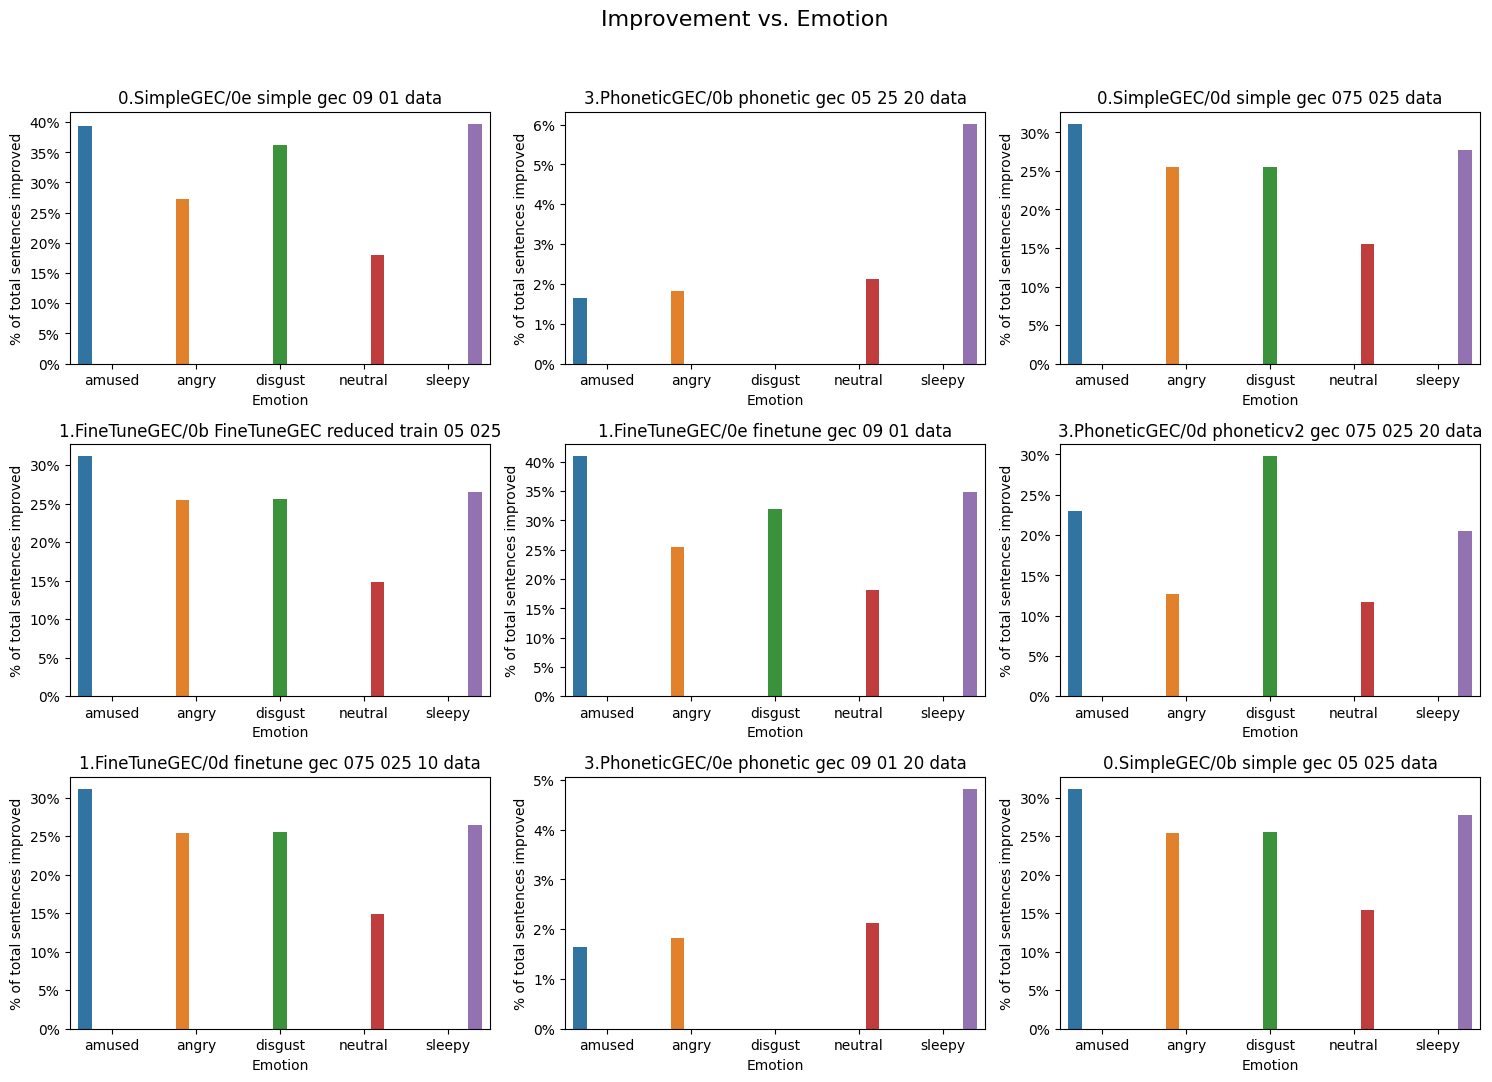

In [ ]:
plot_bar_grid(emotion_df, x_column='emotion', y_column='imp_pct', title='Improvement vs. Emotion', xlabel='Emotion', ylabel='% of total sentences improved')

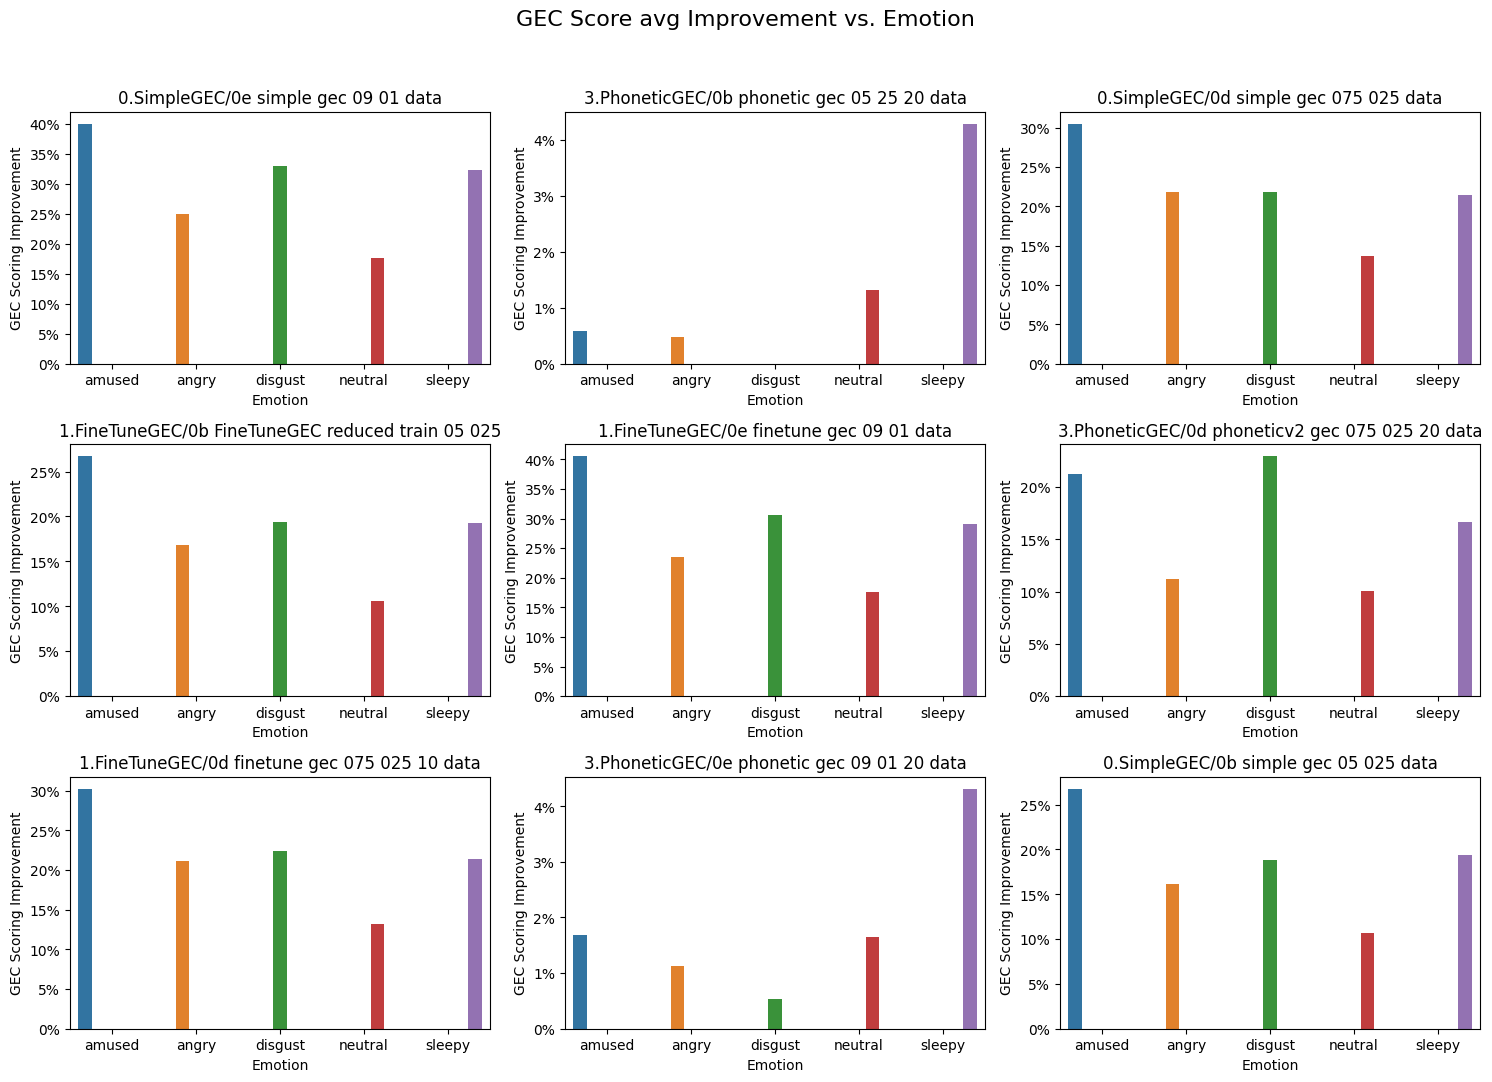

In [ ]:
plot_bar_grid(emotion_df, x_column='emotion', y_column='totalimp_base_GEC', title='GEC Score avg Improvement vs. Emotion', xlabel='Emotion', ylabel='GEC Scoring Improvement')

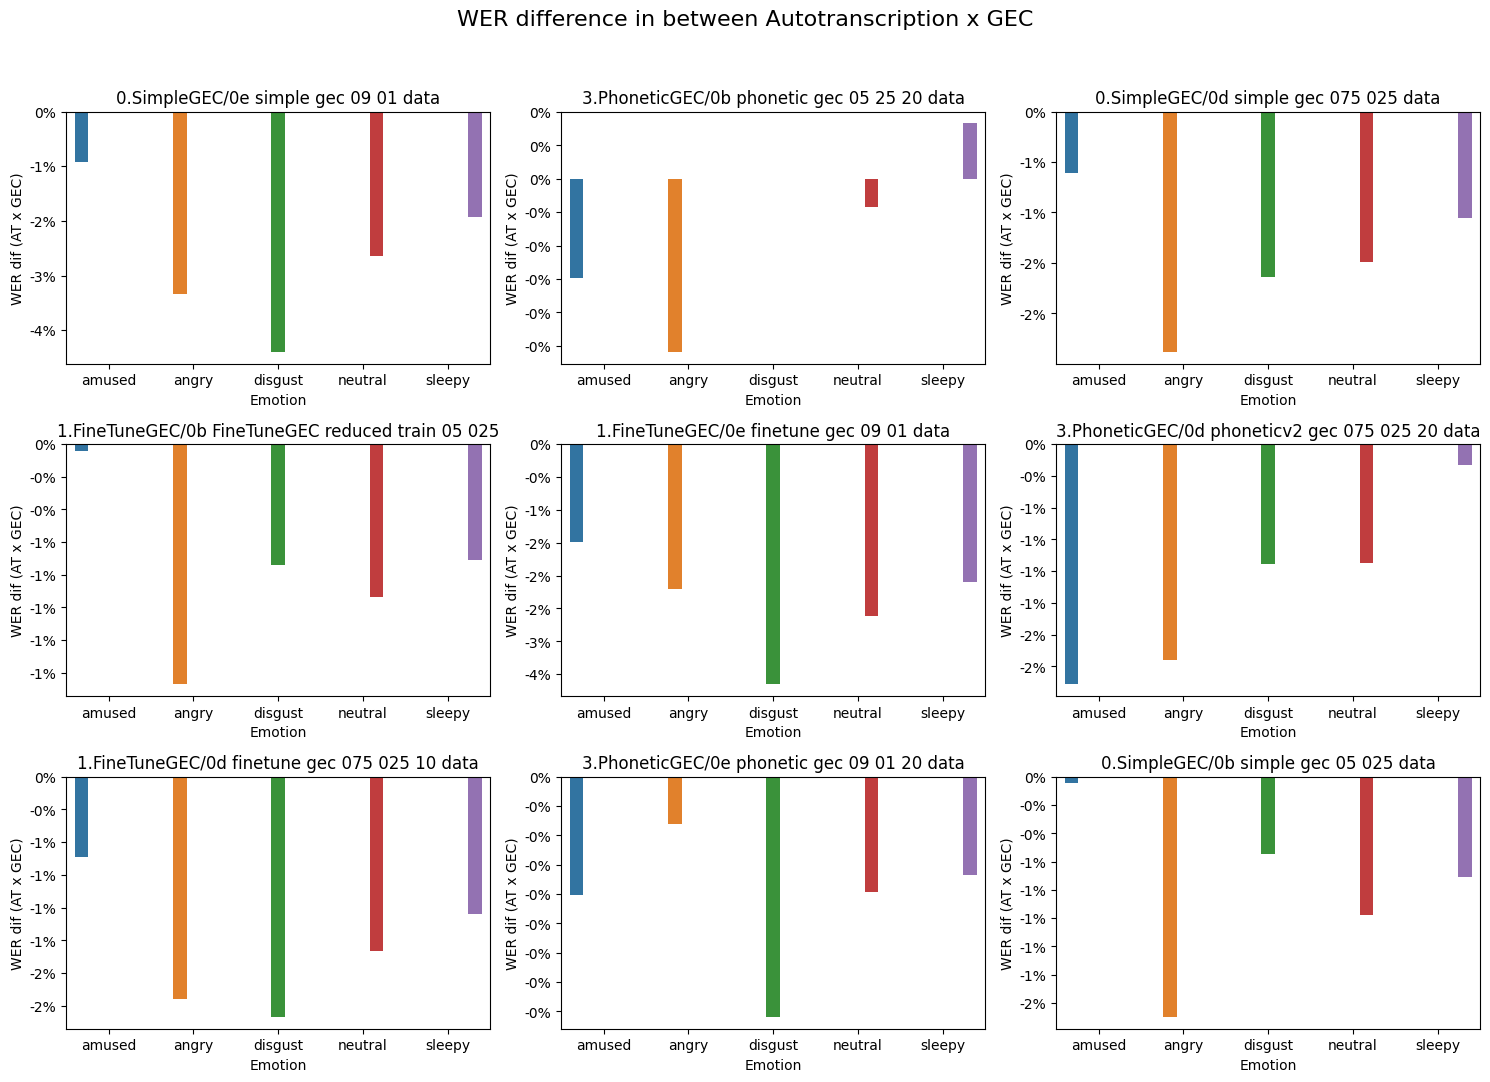

In [ ]:
plot_bar_grid(emotion_df, x_column='emotion', y_column='wer_dif', title='WER difference in between Autotranscription x GEC', xlabel='Emotion', ylabel='WER dif (AT x GEC)')